<a href="https://colab.research.google.com/github/Gokul0Krishna/pytorchpractice/blob/master/attempt_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip "/content/synthetic.zip"
!unzip "/content/washer.v1i.multiclass.zip"
!unzip "/content/test.zip"
!unzip "/content/washer.v4i.multiclass.zip"

Archive:  /content/synthetic.zip
   creating: synthetic/
   creating: synthetic/nut/
  inflating: synthetic/nut/AKM_M10_1_10.png  
  inflating: synthetic/nut/AKM_M10_1_14.png  
  inflating: synthetic/nut/AKM_M10_1_15.png  
  inflating: synthetic/nut/AKM_M10_1_19.png  
  inflating: synthetic/nut/AKM_M10_1_20.png  
  inflating: synthetic/nut/AKM_M10_1_4.png  
  inflating: synthetic/nut/AKM_M10_1_5.png  
  inflating: synthetic/nut/AKM_M10_1_9.png  
  inflating: synthetic/nut/AKM_M12_1_10.png  
  inflating: synthetic/nut/AKM_M12_1_14.png  
  inflating: synthetic/nut/AKM_M12_1_15.png  
  inflating: synthetic/nut/AKM_M12_1_19.png  
  inflating: synthetic/nut/AKM_M12_1_20.png  
  inflating: synthetic/nut/AKM_M12_1_4.png  
  inflating: synthetic/nut/AKM_M12_1_5.png  
  inflating: synthetic/nut/AKM_M12_1_9.png  
  inflating: synthetic/nut/AKM_M14_1_10.png  
  inflating: synthetic/nut/AKM_M14_1_14.png  
  inflating: synthetic/nut/AKM_M14_1_15.png  
  inflating: synthetic/nut/AKM_M14_1_19.png  
 

In [2]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image,ImageFilter, ImageDraw
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision import models,transforms
from torch.utils.data import DataLoader,Dataset

In [3]:
# Dummy implementations for the blur functions (replace with actual implementations)
def add_motion_blur(img, kernel_size=15):
    # Apply motion blur here
    return img  # placeholder

def add_lens_blur(img, radius=2):
    # Apply lens blur here
    return img  # placeholder

class SyntheticDegradation:
    def __init__(self):
        self.blur_types = [
            lambda x: transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))(x),
            lambda x: add_motion_blur(x),
            lambda x: add_lens_blur(x)
        ]

    def __call__(self, img):
        if random.random() > 0.7:  # 70% chance of degradation
            degradation = random.choice([
                self.add_blur,
                self.add_noise,
                self.add_compression
            ])
            img = degradation(img)
        return img

    def add_blur(self, img):
        return random.choice(self.blur_types)(img)

    def add_noise(self, img):
        noise = torch.randn_like(img) * 0.05
        return torch.clamp(img + noise, 0, 1)

    def add_compression(self, img):
        # Simulate JPEG artifacts (using a workaround)
        from io import BytesIO
        from PIL import Image
        buffer = BytesIO()
        img_pil = transforms.ToPILImage()(img)
        img_pil.save(buffer, format='JPEG', quality=random.randint(30, 70))
        img_compressed = Image.open(buffer)
        return transforms.ToTensor()(img_compressed)

In [4]:
# Convert tensor to PIL and back utility
def tensor_to_pil(img):
    return transforms.functional.to_pil_image(img)

def pil_to_tensor(pil_img):
    return transforms.functional.to_tensor(pil_img)

# 1. Add camera noise (ISO-dependent Gaussian noise)
def add_camera_noise(img, iso=1600):
    noise_std = iso / 10000.0  # Empirical scale
    noise = torch.randn_like(img) * noise_std
    return torch.clamp(img + noise, 0.0, 1.0)

# 2. Apply lens distortion (barrel/pincushion warp)
def apply_lens_distortion(img):
    pil_img = tensor_to_pil(img)
    width, height = pil_img.size
    # Apply a mild radial distortion by resizing to a curved mask and back
    distorted = pil_img.transform(
        (width, height),
        Image.QUAD,
        data=(0, 0, width, 0, width - 20, height, 20, height),
        resample=Image.BICUBIC
    )
    return pil_to_tensor(distorted)

# 3a. Add dust particles (black circles)
def add_dust_particles(img):
    pil_img = tensor_to_pil(img)
    draw = ImageDraw.Draw(pil_img)
    for _ in range(random.randint(5, 15)):
        x, y = random.randint(0, pil_img.width), random.randint(0, pil_img.height)
        r = random.randint(1, 4)
        draw.ellipse((x - r, y - r, x + r, y + r), fill=(0, 0, 0))
    return pil_to_tensor(pil_img)

# 3b. Add oil stains (semi-transparent smears)
def add_oil_stains(img):
    pil_img = tensor_to_pil(img).convert("RGBA")
    overlay = Image.new("RGBA", pil_img.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(overlay)
    for _ in range(random.randint(1, 3)):
        x, y = random.randint(0, pil_img.width), random.randint(0, pil_img.height)
        w, h = random.randint(30, 60), random.randint(10, 30)
        draw.ellipse((x, y, x + w, y + h), fill=(100, 100, 100, 60))  # semi-transparent gray
    blended = Image.alpha_composite(pil_img, overlay).convert("RGB")
    return pil_to_tensor(blended)

# 4. Motion blur (using PIL)
def add_motion_blur(img, direction=0):
    pil_img = tensor_to_pil(img)
    # You can simulate motion blur by using a directional blur kernel; PIL doesn't support direct kernel application.
    # As a proxy, we'll rotate and apply a Gaussian blur.
    rotated = pil_img.rotate(direction)
    blurred = rotated.filter(ImageFilter.GaussianBlur(radius=2))
    result = blurred.rotate(-direction)
    return pil_to_tensor(result)

# Main wrapper
def simulate_real_conditions(img):
    """Convert synthetic to realistic degraded images"""
    img = add_camera_noise(img, iso=random.randint(800, 3200))
    img = apply_lens_distortion(img)

    if random.random() > 0.5:
        img = add_dust_particles(img)
        img = add_oil_stains(img)

    if random.random() > 0.6:
        img = add_motion_blur(img, direction=random.randint(0, 360))

    return img

# New section

In [5]:
l=['washer','nut']
realimages=[]
reallabels=[]
for i in os.listdir("/content/washer.v4i.multiclass"):
  for j in os.listdir("/content/washer.v4i.multiclass/"+i):
    if j.endswith(".jpg") == True:
      realimages.append("/content/washer.v4i.multiclass/"+i+"/"+j)
      reallabels.append("washer")

for i in os.listdir("/content/washer.v1i.multiclass"):
    if i.endswith(".txt") == False:
      for j in os.listdir("/content/washer.v1i.multiclass/"+i):
        if j.endswith(".jpg") == True:
          realimages.append("/content/washer.v1i.multiclass/"+i+"/"+j)
          reallabels.append("washer")
a=0
for i in os.listdir("/content/test"):
  for j in os.listdir("/content/test/"+i):
      if a>250:
          break
      realimages.append("/content/test/"+i+"/"+j)
      reallabels.append("nut")
      a+=1

In [6]:
syntheticimages=[]
syntheticlabels=[]
for i in os.listdir("/content/synthetic"):
  for j in os.listdir("/content/synthetic/"+i):
      syntheticimages.append("/content/synthetic/"+i+"/"+j)
      syntheticlabels.append(i)

In [7]:
dfs=pd.DataFrame({'X':syntheticimages,'Y':syntheticlabels})
dfs=pd.get_dummies(dfs,columns=['Y'],dtype=float)
dfs.columns = dfs.columns.str.replace("Y_", "")

dfr=pd.DataFrame({'X':realimages,'Y':reallabels})
dfr=pd.get_dummies(dfr,columns=['Y'],dtype=float)
dfr.columns = dfr.columns.str.replace("Y_", "")

In [8]:
class customdataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x=x
        self.y=y
        self.transform=transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        imgpath=self.x.iloc[index]
        if self.transform:
            image=Image.open(imgpath).convert("RGB")
            image=self.transform(image)
        label_row = self.y.iloc[index, 0:2]
        label_tensor = torch.tensor(label_row.values.astype(np.float32))
        label_index = torch.argmax(label_tensor).item()

        return image,label_index

In [9]:
synthetic_train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomRotation(30),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    SyntheticDegradation(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [10]:
testmodel = models.densenet201(pretrained=True)
for param in testmodel.parameters():  # Freeze all layers
    param.requires_grad = False
testmodel.classifier = nn.Linear(testmodel.classifier.in_features, 2)  # Unfreeze classifier
for param in testmodel.classifier.parameters():
    param.requires_grad = True

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 197MB/s]


In [11]:
from sklearn.model_selection import train_test_split
xstrain, xstest,ystrain,ystest = train_test_split(dfs['X'],dfs[l],random_state=42, test_size=0.2)
traindataset=customdataset(x=xstrain,y=ystrain,transform=synthetic_train_transforms)
valdataset=customdataset(x=xstest,y=ystest,transform=synthetic_train_transforms)

trainloader=DataLoader(traindataset,batch_size=64,shuffle=True)
valloader=DataLoader(valdataset,batch_size=64,shuffle=True,)

In [12]:
testmodel.classifier = torch.nn.Linear(testmodel.classifier.in_features, 2)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params': testmodel.classifier.parameters(), 'lr': 0.001},  # Higher LR for new layers
    {'params': testmodel.features.parameters(), 'lr': 0.00001}    # Lower LR for pretrained
], weight_decay=1e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testmodel = testmodel.to(device)

In [13]:
num_epochs = 2

for epoch in range(num_epochs):
    testmodel.train()
    trunningloss,vrunningloss=0.0,0.0
    ttotal,vtotal = 0,0
    tacc,vacc=0.0,0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = testmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trunningloss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        ttotal += labels.size(0)
        tacc += (predicted == labels).sum().item()


    testmodel.eval()
    with torch.no_grad():
      for inputs, labels in valloader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = testmodel(inputs)
          loss = criterion(outputs, labels)
          vrunningloss += loss.item()

          _, predicted = torch.max(outputs.data, 1)  # Get predicted class
          vtotal += labels.size(0)
          vacc += (predicted == labels).sum().item()

    print("="*20)
    print(f"""Epoch {epoch+1}
          train
          Loss: {trunningloss/len(trainloader)}
          Accuracy: {tacc*100/ttotal}
          val
          Loss: {vrunningloss/len(valloader)}
          Accuracy: {vacc*100/vtotal}
          """)

Epoch 1
          train
          Loss: 0.3545754561200738
          Accuracy: 87.45896257386737
          val
          Loss: 0.19132363299528757
          Accuracy: 95.14435695538057
          
Epoch 2
          train
          Loss: 0.17956851065779725
          Accuracy: 95.07550886408404
          val
          Loss: 0.15549797440568605
          Accuracy: 95.40682414698163
          


In [14]:
real_train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
xstrain, xstest,ystrain,ystest = train_test_split(dfs['X'],dfs[l],random_state=42, test_size=0.3)
straindataset=customdataset(x=xstrain,y=ystrain,transform=synthetic_train_transforms)
svaldataset=customdataset(x=xstest,y=ystest,transform=synthetic_train_transforms)

xrtrain, xrtest,yrtrain,yrtest = train_test_split(dfr['X'],dfr[l],random_state=42, test_size=0.3)
rtraindataset=customdataset(x=xrtrain,y=yrtrain,transform=real_train_transforms)
rvaldataset=customdataset(x=xrtest,y=yrtest,transform=real_train_transforms)


In [16]:
mixedtraindataset = torch.utils.data.ConcatDataset([straindataset, rtraindataset])
# mixedtrainloader = DataLoader(mixedtraindataset, batch_size=64, shuffle=True)

mixedvaldataset = torch.utils.data.ConcatDataset([svaldataset, rvaldataset])
mixedvalloader = DataLoader(mixedvaldataset, batch_size=32, shuffle=False)


In [17]:
real_weight = 3.0  # Higher weight for real data
synthetic_weight = 1.0
weights = torch.tensor([synthetic_weight] * len(straindataset) + [real_weight] * len(rtraindataset))
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
tweighted_mixed_loader = DataLoader(mixedtraindataset, batch_size=32, sampler=sampler)

# weights = torch.tensor([synthetic_weight] * len(svaldataset) + [real_weight] * len(rvaldataset))
# sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
# vweighted_mixed_loader = DataLoader(mixedvaldataset, batch_size=32, sampler=sampler)

In [18]:
for param in testmodel.features.parameters():
    param.requires_grad = False
class_weights = torch.tensor([1.0, 3.0])
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam([
    {'params': testmodel.classifier.parameters(), 'lr': 0.001},
    {'params': testmodel.features.denseblock4.parameters(), 'lr': 0.0001},
    {'params': testmodel.features.denseblock3.parameters(), 'lr': 0.00001}
], weight_decay=1e-5)

In [19]:
num_epochs = 2

for epoch in range(num_epochs):
    testmodel.train()
    trunningloss,vrunningloss=0.0,0.0
    ttotal,vtotal = 0,0
    tacc,vacc=0.0,0.0
    for inputs, labels in tweighted_mixed_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = testmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trunningloss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        ttotal += labels.size(0)
        tacc += (predicted == labels).sum().item()


    testmodel.eval()
    with torch.no_grad():
      for inputs, labels in mixedvalloader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = testmodel(inputs)
          loss = criterion(outputs, labels)
          vrunningloss += loss.item()

          _, predicted = torch.max(outputs.data, 1)  # Get predicted class
          vtotal += labels.size(0)
          vacc += (predicted == labels).sum().item()

    print("="*20)
    print(f"""Epoch {epoch+1}
          train
          Loss: {trunningloss/len(tweighted_mixed_loader)}
          Accuracy: {tacc*100/ttotal}
          val
          Loss: {vrunningloss/len(mixedvalloader)}
          Accuracy: {vacc*100/vtotal}
          """)

Epoch 1
          train
          Loss: 0.12507241721216
          Accuracy: 94.13129973474801
          val
          Loss: 0.08523552401400195
          Accuracy: 97.2952086553323
          
Epoch 2
          train
          Loss: 0.08711684038372416
          Accuracy: 96.12068965517241
          val
          Loss: 0.06833193126339011
          Accuracy: 97.14064914992272
          


In [20]:
!unzip "/content/NPU-BOLT.v1i.yolov5pytorch.zip"

Archive:  /content/NPU-BOLT.v1i.yolov5pytorch.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/images/
 extracting: test/images/AUT-0009_jpg.rf.8e2886663a2f8cd9611493f2393121e4.jpg  
 extracting: test/images/AUT-0022_jpg.rf.a8a50d04a2e030ae95e4a6842bb91041.jpg  
 extracting: test/images/AUT-0023_jpg.rf.7117233d23b273c1b13be360399f2958.jpg  
 extracting: test/images/AUT-0034_jpg.rf.82eaa33fa709aae8a508777ea6155a37.jpg  
 extracting: test/images/AUT-0035_jpg.rf.6918263d65abbe1f6db92b1054741f71.jpg  
 extracting: test/images/AUT-0051_jpg.rf.4af3ad0e57cc29351fa1b0c5fd1927d2.jpg  
 extracting: test/images/AUT-0057_jpg.rf.0915c3bb922acf566cdf8d690c37af0b.jpg  
 extracting: test/images/AUT-0073_jpg.rf.b529408829824f1d655bb23c2f554ae9.jpg  
 extracting: test/images/AUT-0096_jpg.rf.ca2815c28c67db1eadd5052f3fcfc34c.jpg  
 extracting: test/images/AUT-0103_jpg.rf.950cc3a64d1f73b503dddc1ac6da9d7c.jpg  
 extractin

In [21]:
import cv2
l=['train','valid']
image,path=[],[]
t=[image,path]

def load_yolo_annotation(txt_path, img_width, img_height):
    boxes = []
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                cls, x_center, y_center, w, h = map(float, parts)
                # Convert to absolute coordinates
                x1 = int((x_center - w / 2) * img_width)
                y1 = int((y_center - h / 2) * img_height)
                x2 = int((x_center + w / 2) * img_width)
                y2 = int((y_center + h / 2) * img_height)
                boxes.append((int(cls), x1, y1, x2, y2))
    return boxes

def crop_annotated_regions(image_path, label_path):
    cropped_images = []

    # Load the image
    img = cv2.imread(image_path)
    img_height, img_width = img.shape[:2]

    # Load YOLO annotations
    boxes = load_yolo_annotation(label_path, img_width, img_height)

    # Crop and store in list
    for cls_id, x1, y1, x2, y2 in boxes:
        crop = img[y1:y2, x1:x2]
        cropped_images.append((cls_id, crop))

    return cropped_images

In [22]:
import os
for i in range(2):
    a=0
    for j in os.listdir(f"/content/{l[i]}"):
            for k in os.listdir(f"/content/{l[i]}/{j}"):
                 t[a].append(f"/content/{l[i]}/{j}/{k}")
            a+=1

In [23]:
cropedimages=[]
for i in range(len(image)):
    cropedimages.append(crop_annotated_regions(image[i],path[i]))

In [24]:
l=['washer','nut']
realimages=[]
reallabels=[]
for i in os.listdir("/content/washer.v4i.multiclass"):
  for j in os.listdir("/content/washer.v4i.multiclass/"+i):
    if j.endswith(".jpg") == True:
      realimages.append("/content/washer.v4i.multiclass/"+i+"/"+j)
      reallabels.append("washer")

for i in os.listdir("/content/washer.v1i.multiclass"):
    if i.endswith(".txt") == False:
      for j in os.listdir("/content/washer.v1i.multiclass/"+i):
        if j.endswith(".jpg") == True:
          realimages.append("/content/washer.v1i.multiclass/"+i+"/"+j)
          reallabels.append("washer")

for  i in cropedimages:
  img=i[0][1]
  realimages.append(img)
  reallabels.append("nut")

dfr=pd.DataFrame({'X':realimages,'Y':reallabels})
dfr=pd.get_dummies(dfr,columns=['Y'],dtype=float)
dfr.columns = dfr.columns.str.replace("Y_", "")




In [25]:
real_train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [26]:
xrtrain, xrtest,yrtrain,yrtest = train_test_split(dfr['X'],dfr[l],random_state=42, test_size=0.3)
rtraindataset=customdataset(x=xrtrain,y=yrtrain,transform=real_train_transforms)
rvaldataset=customdataset(x=xrtest,y=yrtest,transform=real_train_transforms)
mixedtrainloader = DataLoader(mixedtraindataset, batch_size=16, shuffle=True)
mixedvalloader = DataLoader(mixedvaldataset, batch_size=16, shuffle=True)

In [27]:
for param in testmodel.parameters():
    param.requires_grad = True
optimizer = torch.optim.Adam(testmodel.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

In [28]:
num_epochs = 2

for epoch in range(num_epochs):
    testmodel.train()
    trunningloss,vrunningloss=0.0,0.0
    ttotal,vtotal = 0,0
    tacc,vacc=0.0,0.0
    for inputs, labels in mixedtrainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = testmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trunningloss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        ttotal += labels.size(0)
        tacc += (predicted == labels).sum().item()


    testmodel.eval()
    with torch.no_grad():
      for inputs, labels in mixedvalloader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = testmodel(inputs)
          loss = criterion(outputs, labels)
          vrunningloss += loss.item()

          _, predicted = torch.max(outputs.data, 1)  # Get predicted class
          vtotal += labels.size(0)
          vacc += (predicted == labels).sum().item()

    print("="*20)
    print(f"""Epoch {epoch+1}
          train
          Loss: {trunningloss/len(mixedtrainloader)}
          Accuracy: {tacc*100/ttotal}
          val
          Loss: {vrunningloss/len(mixedvalloader)}
          Accuracy: {vacc*100/vtotal}
          """)

Epoch 1
          train
          Loss: 0.0939744862631732
          Accuracy: 96.35278514588859
          val
          Loss: 0.019445762775527935
          Accuracy: 99.61360123647604
          
Epoch 2
          train
          Loss: 0.045516998119647344
          Accuracy: 98.5079575596817
          val
          Loss: 0.018534382236805272
          Accuracy: 99.38176197836167
          
Epoch 3
          train
          Loss: 0.0378589343039994
          Accuracy: 98.97214854111405
          val
          Loss: 0.010236410207810732
          Accuracy: 99.76816074188562
          


In [29]:
!unzip "/content/finaltest.zip"

Archive:  /content/finaltest.zip
   creating: finaltest/
  inflating: finaltest/10_jpg.rf.2746378b9f91a509adb2df2a5d70d7cf.jpg  
  inflating: finaltest/26_jpg.rf.74a33bc5714c4d679aeb9c1b137c0064.jpg  
  inflating: finaltest/35_jpg.rf.d1028936f944a1cf8ac0995c24bd6571.jpg  
  inflating: finaltest/_classes.csv  


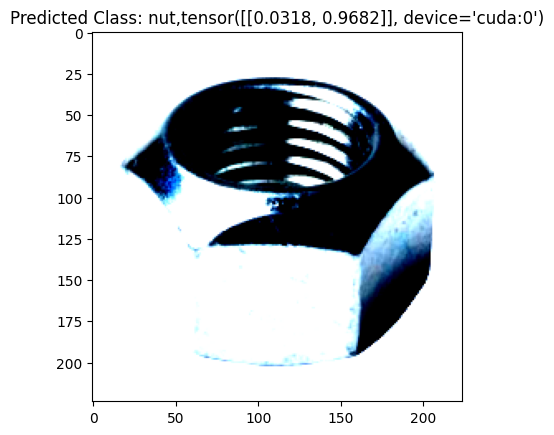

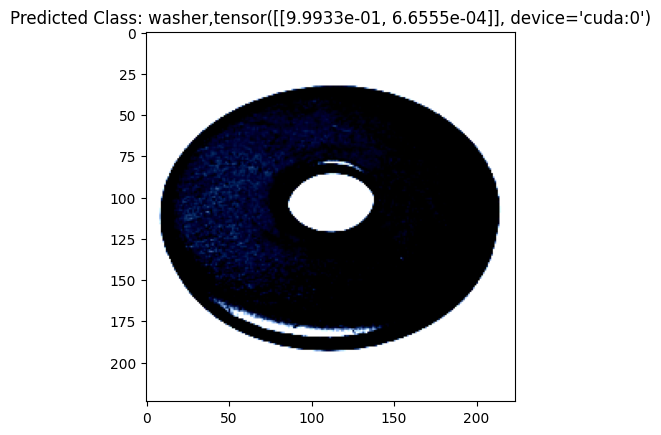

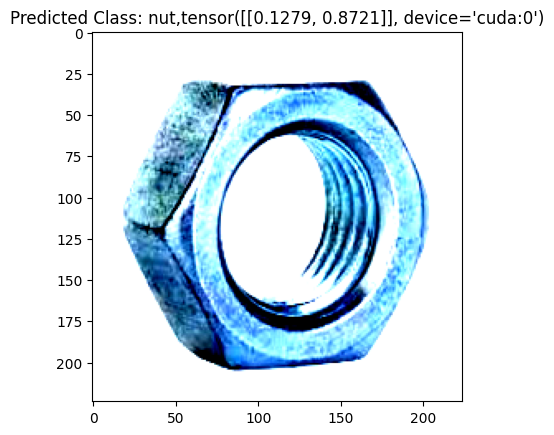

In [30]:

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
import cv2
from matplotlib import pyplot as plt
testmodel.eval()
for i in os.listdir("/content/finaltest"):
  if i.endswith(".jpg"):
    img=cv2.imread("/content/finaltest/"+i)
    # cv2_imshow(img)
    with torch.no_grad():
      img=Image.open("/content/finaltest/"+i).convert("RGB")
      img=preprocess(img)
      img = img.unsqueeze(0)
      img = img.to(device) # Move input to the same device as the model
      ouptut=testmodel(img)
      prob=torch.softmax(ouptut,dim=1)
      predicted_class = torch.argmax(prob).item()
      img=img.squeeze(0).permute(1,2,0).cpu().numpy()
      plt.imshow(img)
      plt.title(f"Predicted Class: {l[predicted_class]},{prob}")
      plt.show()

In [31]:
torch.save(testmodel, 'wtfclassifier.pth')